# Regression Using Fully Connected Neural Network

In [156]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
from torchviz import make_dot
from IPython.display import Image

# Download the data from kaggle. 

<span style="color:red">**Note:** _Please make sure you have API token generated and store under `users/.kaggle/kaggle.json` more information can be found [here](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication). Kaggle cli is required for this. `pip install kaggle`_</span>

Create a dataset directory and unzip the data to that directory.

In [20]:
!kaggle competitions download -c bike-sharing-demand
!mkdir bike-sharing-datasets
!unzip -o bike-sharing-demand.zip -d bike-sharing-datasets/
!rm bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: bike-sharing-datasets: File exists
Archive:  bike-sharing-demand.zip
  inflating: bike-sharing-datasets//sampleSubmission.csv  
  inflating: bike-sharing-datasets//test.csv  
  inflating: bike-sharing-datasets//train.csv  


In [122]:
def dataProcessinng(fileName):
    data = pd.read_csv(fileName)
    # Ensure the 'datetime' column is in datetime format
    data['datetime'] = pd.to_datetime(data['datetime'])

    # Extract components from the datetime column
    data['date'] = data['datetime'].dt.date
    data['year'] = data['datetime'].dt.year
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['weekday'] = data['datetime'].dt.weekday  # 0 = Monday, 6 = Sunday
    data['hour'] = data['datetime'].dt.hour

    # Map numeric season values to season names
    season_mapping = {
        1: 'spring',
        2: 'summer',
        3: 'fall',
        4: 'winter'
    }
    # Apply the mapping to the 'season' column
    data['season'] = data['season'].map(season_mapping)

    # Drop the original 'datetime' column if no longer needed
    data.drop(columns=['datetime'], inplace=True)
    return data

train_data = dataProcessinng('bike-sharing-datasets/train.csv')

print('\nTraining Data: \n', train_data.head())



Training Data: 
    season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0  spring        0           0        1  9.84  14.395        81        0.0   
1  spring        0           0        1  9.02  13.635        80        0.0   
2  spring        0           0        1  9.02  13.635        80        0.0   
3  spring        0           0        1  9.84  14.395        75        0.0   
4  spring        0           0        1  9.84  14.395        75        0.0   

   casual  registered  count        date  year  month  day  weekday  hour  
0       3          13     16  2011-01-01  2011      1    1        5     0  
1       8          32     40  2011-01-01  2011      1    1        5     1  
2       5          27     32  2011-01-01  2011      1    1        5     2  
3       3          10     13  2011-01-01  2011      1    1        5     3  
4       0           1      1  2011-01-01  2011      1    1        5     4  


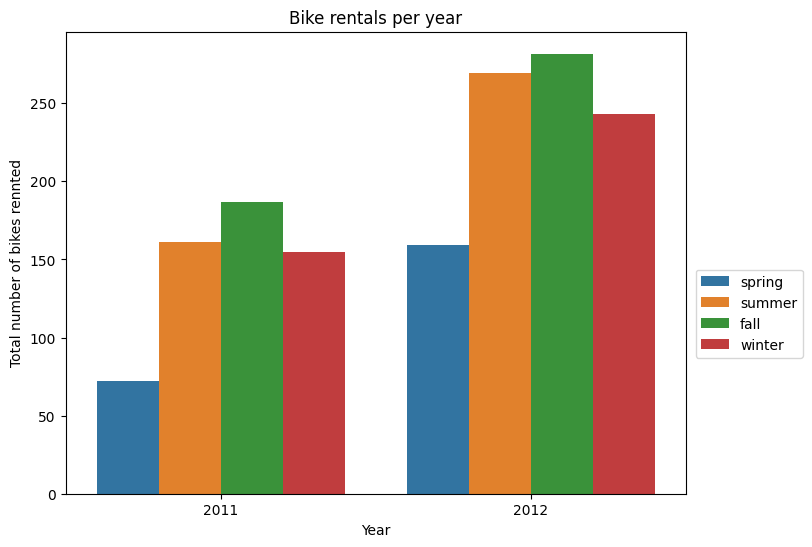

In [123]:
plt.figure(figsize=(8, 6))
sns.barplot(x='year', y='count', hue='season', data=train_data, errorbar=None)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5))

plt.xlabel('Year')
plt.ylabel('Total number of bikes rennted')
plt.title('Bike rentals per year')
plt.show()

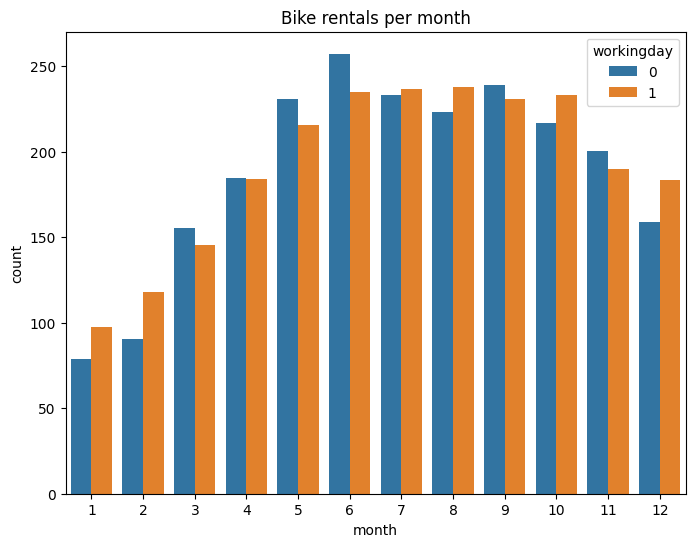

In [124]:
plt.figure(figsize=(8, 6))
sns.barplot(x='month', y='count', hue='workingday', data=train_data, errorbar=None)
plt.title('Bike rentals per month')
plt.show()

Text(0, 0.5, 'Total number of bikes rented')

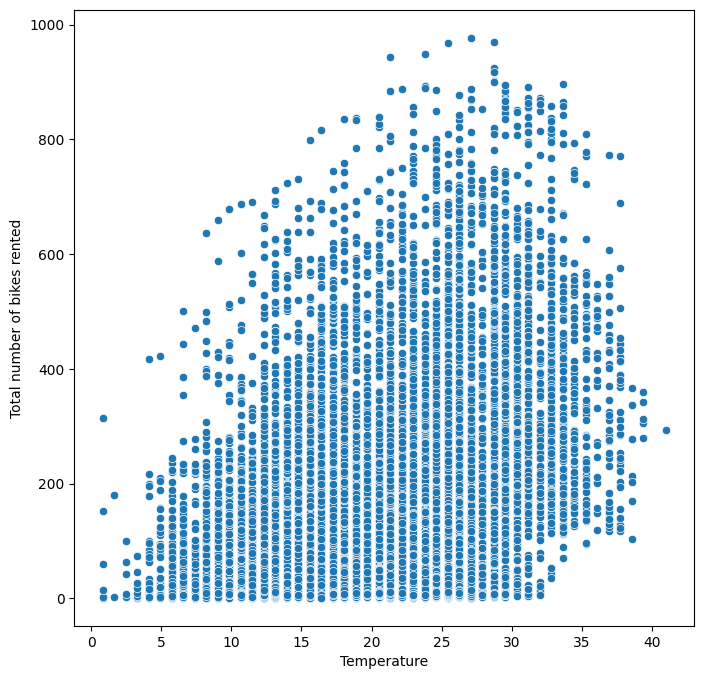

In [125]:
plt.figure(figsize=(8, 8))
fig = sns.scatterplot(x='temp', y='count', data=train_data)
plt.xlabel('Temperature')
plt.ylabel('Total number of bikes rented')


In [126]:
# Convert season column to categorical type using 1-hot encoding
train_data = pd.get_dummies(train_data, columns=['season'], dtype=int)
train_data.sample(5)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,weekday,hour,season_fall,season_spring,season_summer,season_winter
632,0,1,1,7.38,8.335,40,16.9979,2,67,69,2011-02-09,2011,2,9,2,13,0,1,0,0
3739,0,1,2,22.14,25.760,88,26.0027,22,351,373,2011-09-06,2011,9,6,1,18,1,0,0,0
7207,0,1,2,17.22,21.210,77,15.0013,36,199,235,2012-04-18,2012,4,18,2,16,0,0,1,0
9056,0,0,2,26.24,29.545,78,7.0015,76,267,343,2012-08-19,2012,8,19,6,17,1,0,0,0
2197,0,1,2,22.14,25.760,94,6.0032,6,17,23,2011-05-18,2011,5,18,2,11,0,0,1,0


# Feature Engineering

Choose features which are relevant for predictions

In [130]:
columns = ['registered', 'holiday', 'weekday', 'weather', 'temp', 'atemp', 'season_spring', 'season_summer', 'season_fall', 'season_winter']

features = train_data[columns]
features.head()

,registered,holiday,weekday,weather,temp,atemp,season_spring,season_summer,season_fall,season_winter
0,13,0,5,1,9.84,14.395,1,0,0,0
1,32,0,5,1,9.02,13.635,1,0,0,0
2,27,0,5,1,9.02,13.635,1,0,0,0
3,10,0,5,1,9.84,14.395,1,0,0,0
4,1,0,5,1,9.84,14.395,1,0,0,0


In [131]:
target = train_data[['count']]
target.head()

,count
0,16
1,40
2,32
3,13
4,1


In [132]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2)


In [133]:
# convert data to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
Y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
x_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

In [134]:
X_train_tensor.shape

torch.Size([8708, 10])

In [135]:
Y_train_tensor.shape

torch.Size([8708, 1])

In [137]:
train_dataset = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = data_utils.DataLoader(train_dataset, batch_size=100, shuffle=True)


In [140]:
print('Number of batches : ', len(train_loader))

Number of batches :  88


In [141]:
features_batch, target_batch = next(iter(train_loader))
print('Features batch shape : ', features_batch.shape)

Features batch shape :  torch.Size([100, 10])


In [142]:
input_size = X_train_tensor.shape[1]
output_size = 1
hiden_layer = 10

loss_fn = nn.MSELoss()

In [143]:
model = nn.Sequential(
    nn.Linear(input_size, hiden_layer),
    nn.Linear(hiden_layer, output_size)
)

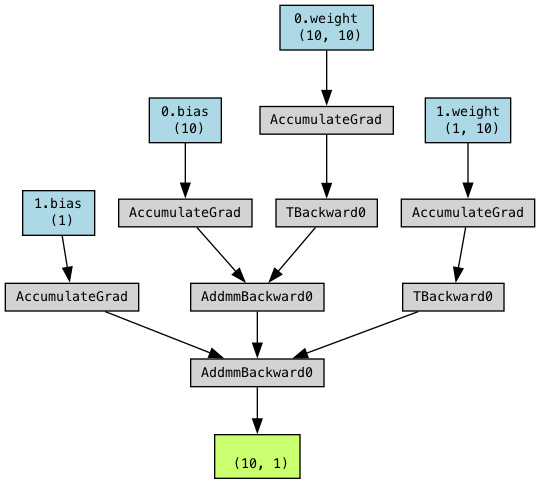

In [ ]:
# Note that graphviz must be installed in the system for this to work
# Visualize the model using torchviz
dummy_input = torch.zeros([10, input_size])
make_dot(model(dummy_input), params=dict(model.named_parameters())).render("model", format="png")

# Display the saved image
Image(filename="model.png")

In [157]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [158]:
total_step = len(train_loader)
num_epochs = 10000

for epoch in range(num_epochs+1):
    for i, (features_batch, target_batch) in enumerate(train_loader):
        # Forward pass
        outputs = model(features_batch)
        loss = loss_fn(outputs, target_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 2000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}] Loss: {loss.item():.4f}')

Epoch [2000/10000], Step [88/88] Loss: 916.2812


KeyboardInterrupt: 